In [12]:
import matplotlib.pyplot as plt
import pickle 
from pathlib import Path as P
from matplotlib.patches import Rectangle as Rec
import numpy as np
from pcdet.utils import calibration_kitti
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
from vod.visualization.settings import label_color_palette_2d


In [13]:
frame_id = '004850'
# frame_id = '007008'
dpp_result = {}
for layer_id in range(0, 4):
    dpp_enable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_enable_layer_%s.npy' % (frame_id, layer_id))
    dpp_disable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_disable_layer_%s.npy' % (frame_id, layer_id))
    layer_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_layer_xyz_layer_%s.npy' % (frame_id, layer_id))
    sample_gt = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_gt_layer_%s.npy' % (frame_id, layer_id))
    dpp_result[layer_id] = {'dpp_enable_xyz': dpp_enable_xyz, 'dpp_disable_xyz': dpp_disable_xyz, 'layer_xyz': layer_xyz, 'sample_gt': sample_gt}

In [14]:
def transform_anno(loc, frame_id, is_radar=True, is_test=False):
    x, y, z = loc[0], loc[1], loc[2]
    split = 'testing' if is_test else 'training'

    calib_path = "/root/hantao/CenterPoint-KITTI/data/kitti/%s/calib/%s.txt"%(split, frame_id)
    calib = calibration_kitti.Calibration(calib_path)
    loc = np.array([[x,y,z]])
    loc_lidar = calib.rect_to_lidar(loc)
    x,y,z = loc_lidar[0]
    return x,y,z


def get_rot_corner(x,y,l,w,a):

    s,c = np.sin(a),np.cos(a)

    corner_x = x - l/2
    corner_y = y - w/2

    corner_x -= x
    corner_y -= y

    new_corner_x = corner_x*c - corner_y*s 
    new_corner_y = corner_x*s + corner_y*c

    new_corner_x += x
    new_corner_y += y

    return new_corner_x,new_corner_y

def anno2plt(anno, color_dict, lw, frame_id, xz=False, is_radar=True, is_test=False):
    dim = anno[:, 3:6]
    loc = anno[:, 0:3]
    rot = anno[:, 6:7]
    cls = anno[:, 7:8]
    angle = rot
    rec_list = []
    for idx in range(dim.shape[0]):
        cls_id = int(cls[idx][0])
        print(cls_id)
        if cls_id not in color_dict:
            color = 'gray'
        else:
            color = color_dict[cls_id]  
        print(color)
        if xz:
            x, _, y = transform_anno(loc[idx], frame_id, is_radar=is_radar, is_test=is_test)
            l, w, _ = dim[idx]
            ang = -angle[idx]* 0
        else:
            # x, y, z = transform_anno(loc[idx], frame_id, is_radar=is_radar, is_test=is_test)
            x, y, z = loc[idx]
            l, h, w  = dim[idx]
            ang = angle[idx]
            ax,ay = get_rot_corner(x,y,l,w,ang)
            ang = ang * 180 / 3.14

        rec_list += [Rec((ax, ay), l, w, ang, fill=False, color=color,lw=lw)]
    return rec_list

def drawBEV(ax, pts, centers, annos, color_dict, frame_id, ax_title, cls_name, ext_legends=[], is_radar=True, is_test=False):


    # 3. draw bbx
    rec_list = anno2plt(annos, color_dict, 1, frame_id=frame_id, xz=False, is_radar=is_radar, is_test=is_test)
    
    # 1. draw original points if exist
    if pts is not None:
        x = pts[:, 0]
        y = pts[:, 1]
        ax.scatter(x, y, c='black', s=2.0)
    # 2. overlay centers
    if centers is not None:
        cx = centers[:, 1]
        cy = centers[:, 2]
        ax.scatter(cx, cy, c='red', s=2.0)
    
    for rec in rec_list:
        ax.add_patch(rec)

    legend_elements = [Patch(facecolor='white', edgecolor=v, label=cls_name[k-1]) for i, (k, v) in enumerate(color_dict.items())]
    if centers is not None:
        legend_elements += [Line2D([0], [0], marker='o', color='w', label='FG points',
                          markerfacecolor='r', markersize=10)]
    legend_elements += ext_legends
    ax.legend(handles=legend_elements, loc=1)
    ax.set_title(ax_title)

In [15]:
def draw_dpp(layer_id):
        color_dict = {}
        cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
        for i, v in enumerate(cls_name):
                color_dict[i+1] = label_color_palette_2d[v]

        plt.rcParams['figure.dpi'] = 150
        plt.xlim(-0,75)
        plt.ylim(-30,30)
        ax = plt.gca()
        points = dpp_result[layer_id]['layer_xyz']
        annons = dpp_result[layer_id]['sample_gt']
        dpp_enable_points = dpp_result[layer_id]['dpp_enable_xyz']
        dpp_disable_points = dpp_result[layer_id]['dpp_disable_xyz']

        ax.scatter(dpp_disable_points[:,0], dpp_disable_points[:,1], c='black', s=0.3)
        ax.scatter(dpp_enable_points[:,0], dpp_enable_points[:,1], c='orange', s=0.3)
        drawBEV(ax, None, None, annons, color_dict, frame_id, 'DPP BEV Visluzation at Layer %s'%(layer_id+1), cls_name, ext_legends=[], is_radar=True, is_test=False)

1
(0.0, 0.0, 1.0)
1
(0.0, 0.0, 1.0)
3
(1, 0.0, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
3
(1, 0.0, 0.0)


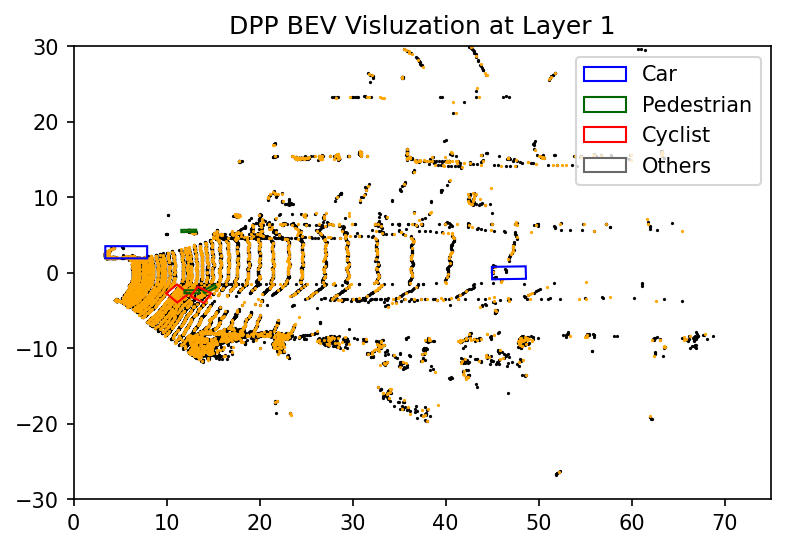

In [16]:
draw_dpp(0)

1
(0.0, 0.0, 1.0)
1
(0.0, 0.0, 1.0)
3
(1, 0.0, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
3
(1, 0.0, 0.0)


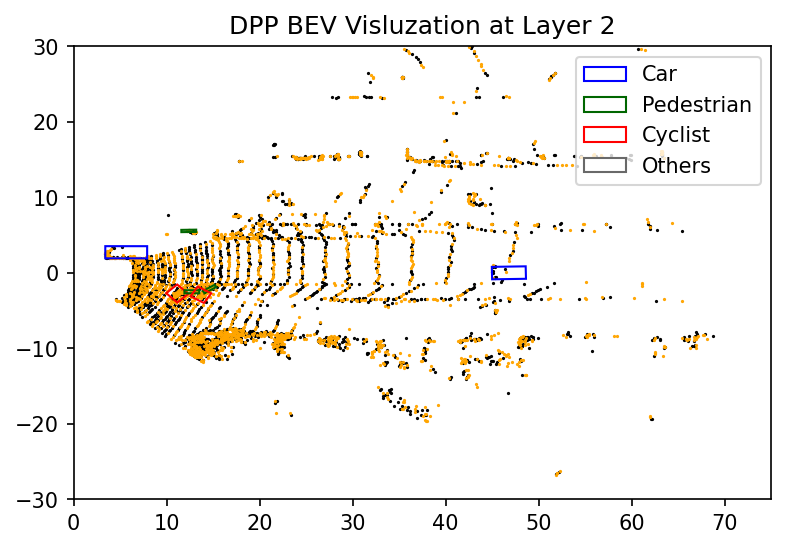

In [17]:
draw_dpp(1)

1
(0.0, 0.0, 1.0)
1
(0.0, 0.0, 1.0)
3
(1, 0.0, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
3
(1, 0.0, 0.0)


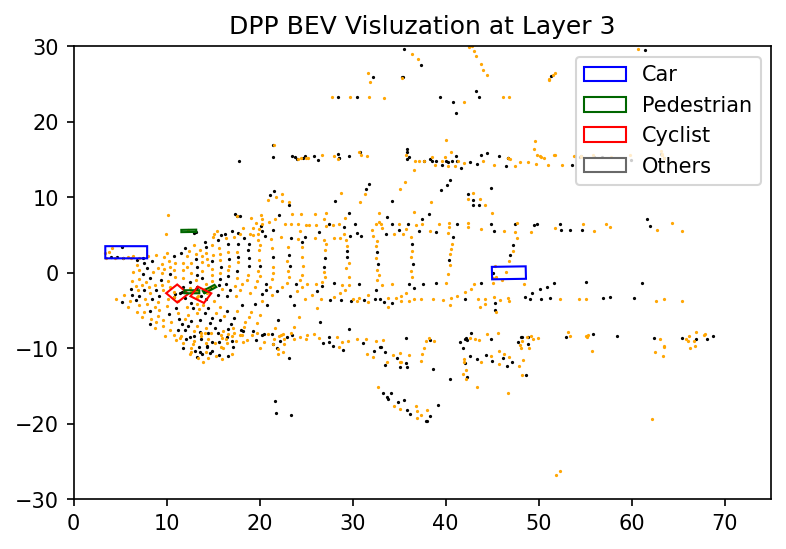

In [18]:
draw_dpp(2)

1
(0.0, 0.0, 1.0)
1
(0.0, 0.0, 1.0)
3
(1, 0.0, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
2
(0.0, 0.4, 0.0)
3
(1, 0.0, 0.0)


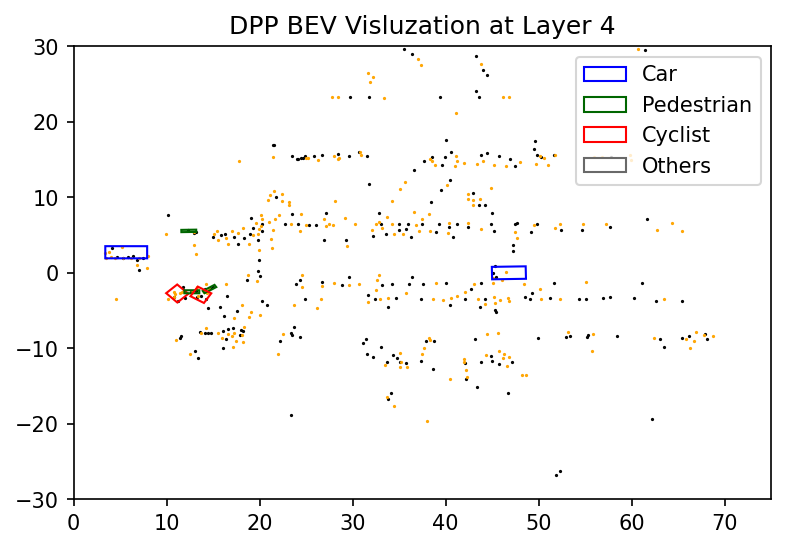

In [19]:
draw_dpp(3)

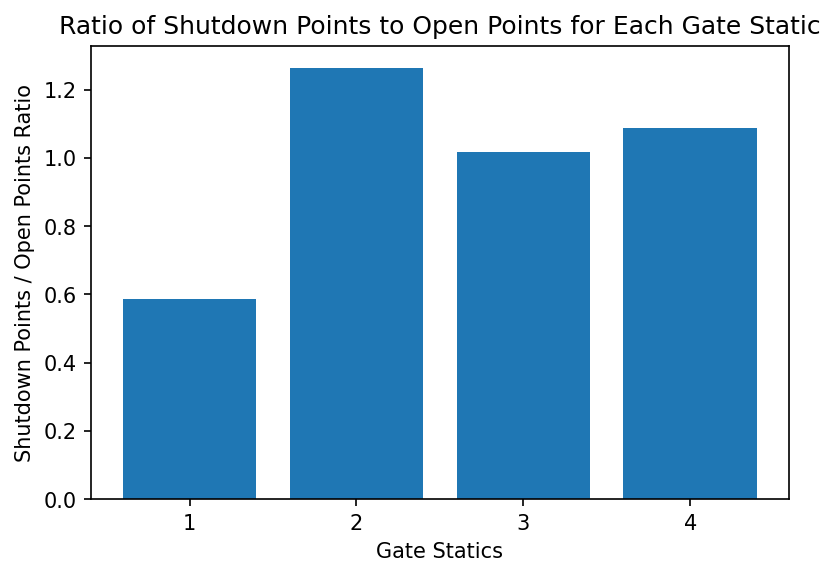

In [20]:
import matplotlib.pyplot as plt

# Data
shutdown_points = [22833299, 8620276, 1946112, 1004874]
open_points = [38917997, 6817548, 1913344, 924854]

# Calculate the ratio of shutdown points to open points
ratio = [shutdown / open for shutdown, open in zip(shutdown_points, open_points)]

# Create the plot
fig, ax = plt.subplots()
ax.bar(range(1, len(ratio) + 1), ratio)

# Customize the plot
ax.set_xlabel('Gate Statics')
ax.set_ylabel('Shutdown Points / Open Points Ratio')
ax.set_title('Ratio of Shutdown Points to Open Points for Each Gate Static')
ax.set_xticks(range(1, len(ratio) + 1))

# Show the plot
plt.show()


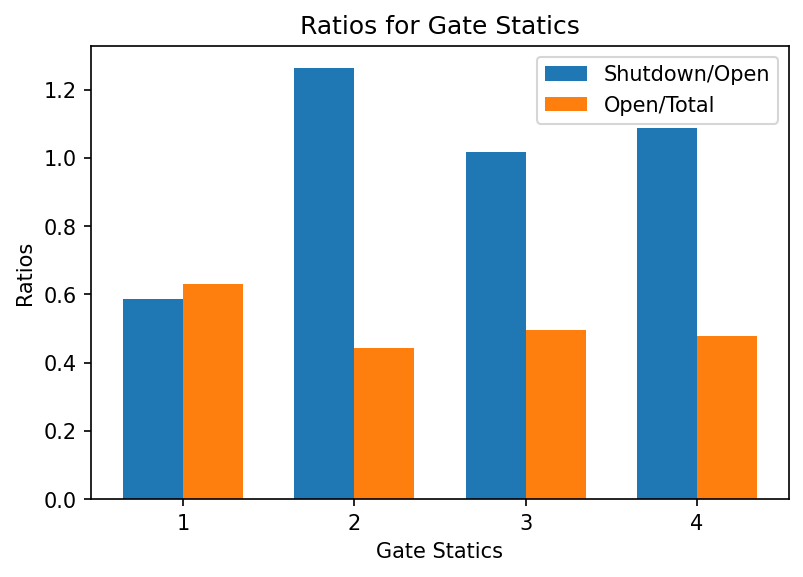

In [21]:
import matplotlib.pyplot as plt

# Data
shutdown_points = [22833299, 8620276, 1946112, 1004874]
open_points = [38917997, 6817548, 1913344, 924854]

# Calculate the ratio of shutdown points to open points
ratio_shutdown_open = [shutdown / open for shutdown, open in zip(shutdown_points, open_points)]

# Calculate the ratio of open points to total points
total_points = [shutdown + open for shutdown, open in zip(shutdown_points, open_points)]
ratio_open_total = [open / total for open, total in zip(open_points, total_points)]

# Create the plot
fig, ax = plt.subplots()

bar_width = 0.35
x = range(1, len(ratio_shutdown_open) + 1)

ax.bar(x, ratio_shutdown_open, width=bar_width, label="Shutdown/Open")
ax.bar([xi + bar_width for xi in x], ratio_open_total, width=bar_width, label="Open/Total")

# Customize the plot
ax.set_xlabel('Gate Statics')
ax.set_ylabel('Ratios')
ax.set_title('Ratios for Gate Statics')
ax.set_xticks([xi + bar_width / 2 for xi in x])
ax.set_xticklabels(x)
ax.legend()

# Show the plot
plt.show()


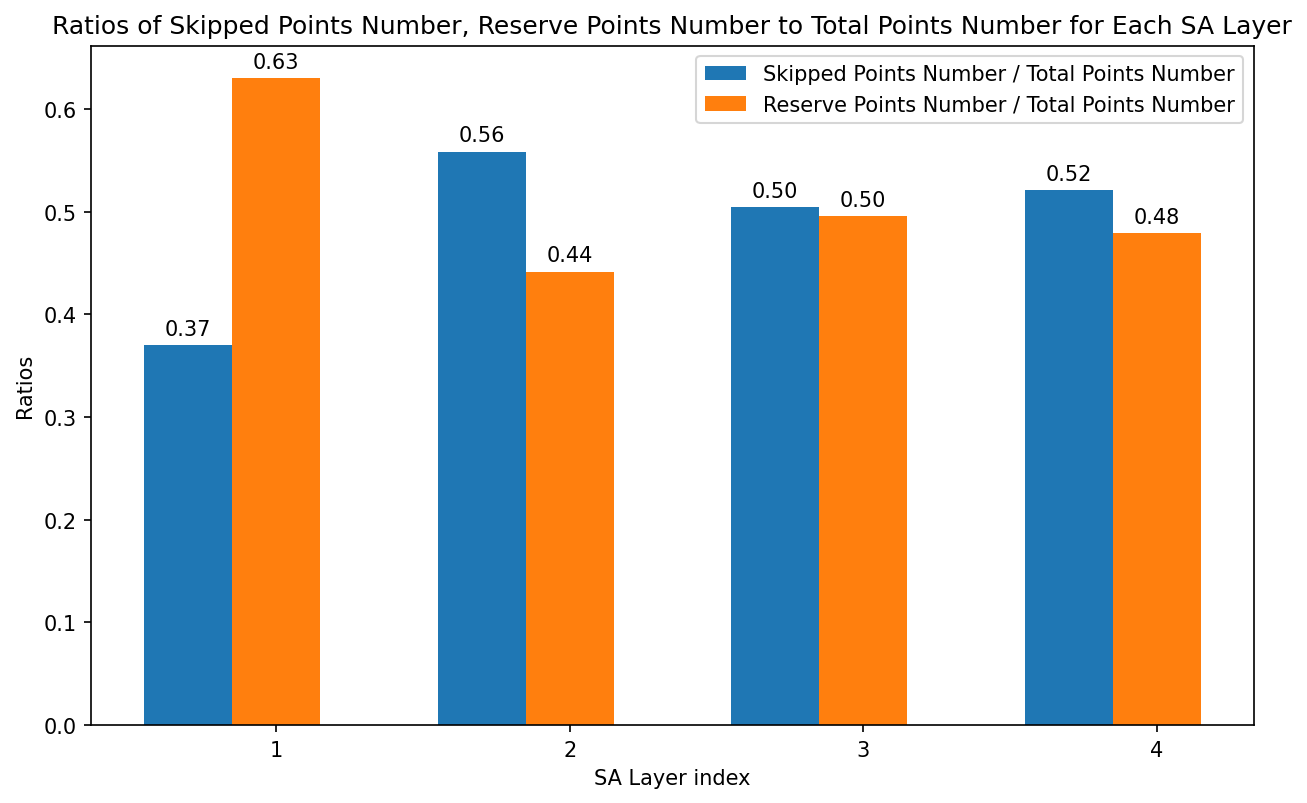

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
shutdown_points = [22833299, 8620276, 1946112, 1004874]
open_points = [38917997, 6817548, 1913344, 924854]

# Calculate the ratios
total_points = [shutdown + open for shutdown, open in zip(shutdown_points, open_points)]
ratio_shutdown_total = [shutdown / total for shutdown, total in zip(shutdown_points, total_points)]
ratio_open_total = [open / total for open, total in zip(open_points, total_points)]

# Create the plot
x = np.arange(len(shutdown_points))  # label locations
width = 0.3  # bar width

fig, ax = plt.subplots(figsize=(10, 6))  
rects1 = ax.bar(x - width, ratio_shutdown_total, width, label='Skipped Points Number / Total Points Number')
rects2 = ax.bar(x, ratio_open_total, width, label='Reserve Points Number / Total Points Number')

# Customize the plot
ax.set_xlabel('SA Layer index')
ax.set_ylabel('Ratios')
ax.set_title('Ratios of Skipped Points Number, Reserve Points Number to Total Points Number for Each SA Layer')
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4'])
ax.legend()

# Function to auto-label bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()
